In [1]:
import arff

from scipy import sparse
decoder = arff.ArffDecoder()
d = decoder.decode(open('enron-train.arff', 'r'), encode_nominal=True, return_type=arff.COO)
data = d['data'][0]
row = d['data'][1]
col = d['data'][2]
matrix = sparse.coo_matrix((data, (row, col)), shape=(max(row)+1, max(col)+1))

In [2]:
import numpy as np
y = matrix.A[:,1001:]

In [3]:
from scipy.stats import chi2_contingency
count_11 = np.matmul(y.transpose(), y) #Aij is sum of 11 of label i and label j
count_10 = np.matmul(y.transpose(), 1 - y) 
count_01 = np.matmul(1 - y.transpose(), y)
count_00 = np.matmul(1 - y.transpose(), 1 - y)

# chi2 testing on pairwise dependencies
num_vars = y.shape[1] # num labels
p_value = np.ones([num_vars,num_vars])
for i in range(num_vars):
    for j in range(num_vars):
        c = np.array([[count_11[i, j], count_10[i, j]], [count_01[i, j], count_00[i, j]]])
        if (np.sum(c, 0) > 0).all() and (np.sum(c, 1) > 0).all():
            _, p_value[i, j], _, _ = chi2_contingency(c)
        else:
            p_value[i,j] = 1

skeleton = 1*(p_value <= 0.05)


def _calc_prob(y):
    marginal_1 = np.sum(y, 0)/len(y) # vector containing probability a given label is 1
    marginal_0 = 1-marginal_1
    joint_11 = np.matmul(y.transpose(), y)/len(y) # matrix prob that 11 occurs in ith, jth position in a given row
    joint_01 = np.matmul(1-y.transpose(), y)/len(y)
    joint_10 = np.matmul(y.transpose(), 1-y)/len(y)
    joint_00 = np.matmul(1-y.transpose(), 1-y)/len(y)
    conditional_11 = joint_11/marginal_1  # probability of dim=0 (row) given dim=1 (column)
    conditional_01 = joint_01/marginal_1 
    conditional_10 = joint_10/marginal_0
    conditional_00 = joint_00/marginal_0
    return {'marginal_1': marginal_1, 'marginal_0': marginal_0,
            'joint_11': joint_11, 'conditional_11': conditional_11,
            'joint_01': joint_01, 'conditional_01': conditional_01,
            'joint_10': joint_10, 'conditional_10': conditional_10,
            'joint_00': joint_00, 'conditional_00': conditional_00
            }

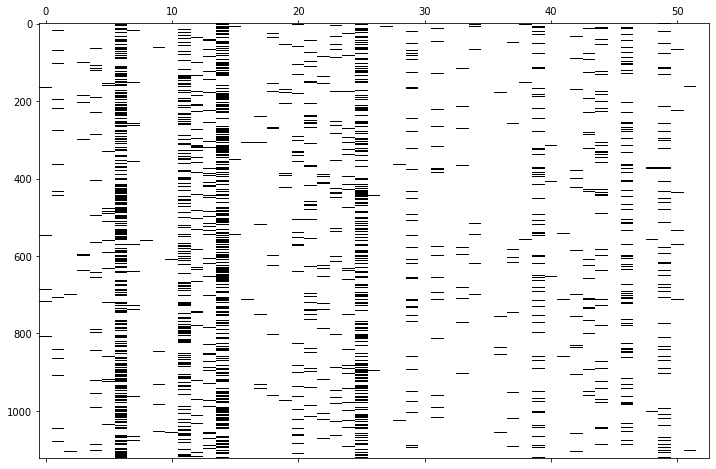

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.spy(y,aspect='auto')

c:\users\david\anaconda3\envs\graphenv\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
c:\users\david\anaconda3\envs\graphenv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
c:\users\david\anaconda3\envs\graphenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(<matplotlib.image.AxesImage at 0x1f7bfa10278>,
 <matplotlib.colorbar.Colorbar at 0x1f7bfa51630>)

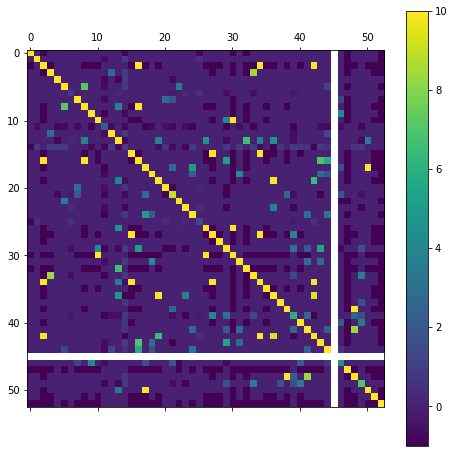

In [5]:
p = _calc_prob(y)
marginal = p['marginal_1']
conditional = p['conditional_11'] # the chi2 test tells us whether the difference between conditional and marginal is significant
pulling = skeleton * (conditional > marginal[:, None]) # matrix, where each element is 1 if the presence if ith label increases chance of jth label AND chi2 test satisfied
pushing = skeleton * (conditional < marginal[:, None])
# plt.matshow(conditional)
plt.figure(figsize=(8,8))
plt.matshow(skeleton * (np.divide(conditional - marginal[:, None],marginal[:, None])),fignum=0,vmax=10), plt.colorbar()

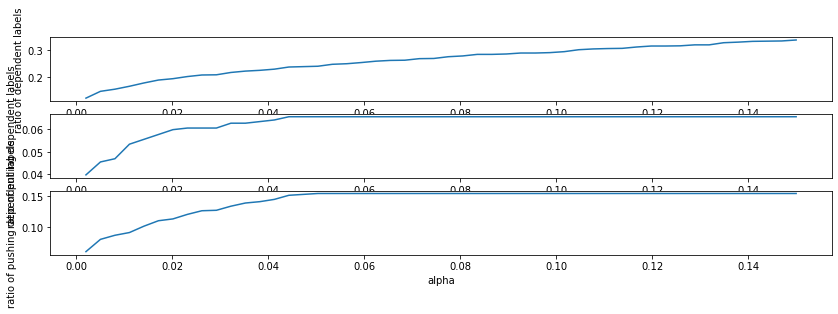

In [11]:
plot_y = []
plot_x = np.linspace(0.002,0.15,50)
pulling_plot = []
pushing_plot = []
for num in plot_x:
    plot_y.append((np.count_nonzero(p_value<num)-num_vars)/(p_value.size-num_vars))
    pulling_plot.append((np.count_nonzero(np.logical_and(pulling,(p_value<num)))-num_vars)/(p_value.size-num_vars))
    pushing_plot.append((np.count_nonzero(np.logical_and(pushing,(p_value<num)))-num_vars)/(p_value.size-num_vars))
plt.figure(figsize=(14,4))
plt.subplot(311)
plt.plot(plot_x,plot_y)
plt.xlabel('alpha')
plt.ylabel('ratio of dependent labels')
plt.subplot(312)
plt.plot(plot_x,pulling_plot)
plt.xlabel('alpha')
plt.ylabel('ratio of pulling dependent labels')
plt.subplot(313)
plt.plot(plot_x,pushing_plot)
plt.xlabel('alpha')
plt.ylabel('ratio of pushing dependent labels')
plt.show()